# Adjusted Phase 1  Generation Tool
Below are packages imported during development, most of which are used below
Read through the worksheet, and enter any values in the cells headed 'Enter' below.  Then click 'Cell' in the menu above, and 'Run All.'

In [8]:
#%matplotlib inline
%matplotlib notebook

import matplotlib as mp

import pandas as pd

import numpy as np

import scipy as sp

import scipy.linalg as spl

import glob

import json

import urllib2

from datetime import datetime 

import dateutil.parser as dp

import matplotlib.pyplot as pl

import re

import obspy

from obspy.core import UTCDateTime

import geomagio

from geomagio.edge import EdgeFactory

#from geomagio.Algorithm import DeltaFAlgorithm

Example url for baseline web service

https://geomag.usgs.gov/baselines/observation.json.php?observatory=BOU&starttime=2016-01-01&endtime=2016-10-07

## Enter the Observatory in the cell below as a string, similar to the following example:

```python
obs_code = 'BOU'
```

In [9]:
obs_code = 'BOU'

## Enter the start date and end date for which you'd like to request baseline measurements
If you choose a year's worth, that will result in the mean delta F for adjusted data being closest to 0, but will amplify the daily variation.  If you choose a shorter time period closer to the present, the daily variation will remain small, but the mean delta F will be biased by seasonal variation.  If the baseline service is called without dates, it will return the last one month's baseline measurements.

NOTE: the datetimes used to index sets of Absolutes in the database are not necessarily associated with the datetimes of the actual measurements made, although they seem to be reliably on the same day at least. A github ticket was submitted to change this web service behavior, but for now, assume the start_date and end_date below are somewhat fuzzy, or just limit the search to whole days.

In [194]:
start_date = '2017-03-09T00:00:00Z'

# convert to unix epoch time (seconds since 1/1/1970)
start_epoch = (dp.parse(start_date, ignoretz=True) - datetime.utcfromtimestamp(0)).total_seconds()

In [195]:
end_date = '2017-03-22T00:00:00Z'

# convert to unix epoch time (seconds since 1/1/1970)
end_epoch = (dp.parse(end_date, ignoretz=True) - datetime.utcfromtimestamp(0)).total_seconds()

In [196]:
# pull baseline info from USGS Geomagnetism Program's web service
baseline_url = 'https://geomag.usgs.gov/baselines/observation.json.php'
full_url = baseline_url + '?observatory=' + obs_code + '&starttime=' + start_date + '&endtime=' + end_date
response = urllib2.urlopen(full_url)
parsed_response = json.load(response)


In [199]:
# extract only complete and validated baseline sets; also,
# filter on times to partially address issues with database time stamps
h_abs = []
d_abs = []
z_abs = []
h_ord = []
d_ord = []
z_ord = []
h_t = []
d_t = []
z_t = []

for datum in parsed_response['data']:
    for reading in datum['readings']:
        if (reading['H']['absolute'] is not None
           and reading['D']['absolute'] is not None
           and reading['Z']['absolute'] is not None
           and reading['H']['baseline'] is not None
           and reading['D']['baseline'] is not None
           and reading['Z']['baseline'] is not None
           and reading['H']['valid'] is True
           and reading['D']['valid'] is True
           and reading['Z']['valid'] is True
           and reading['H']['end'] >= start_epoch
           and reading['D']['end'] >= start_epoch
           and reading['Z']['end'] >= start_epoch
           and reading['H']['end'] <= end_epoch
           and reading['D']['end'] <= end_epoch
           and reading['Z']['end'] <= end_epoch):
            h_abs.append(reading['H']['absolute'])
            d_abs.append(reading['D']['absolute'])
            z_abs.append(reading['Z']['absolute'])
            h_ord.append(reading['H']['absolute'] - reading['H']['baseline'])
            d_ord.append(reading['D']['absolute'] - reading['D']['baseline'])
            z_ord.append(reading['Z']['absolute'] - reading['Z']['baseline'])
            h_t.append(reading['H']['end'])
            d_t.append(reading['D']['end'])
            z_t.append(reading['Z']['end'])

# perhaps a separate pier_correction  should be associated with each datum...
# revisit and fix if necessary -EJR
last_datum = parsed_response['data'][-1]
pier_correction = float(last_datum['pier']['correction'])

# convert unix times to Python datetimes
h_dt = [datetime.utcfromtimestamp(ut) for ut in h_t]
d_dt = [datetime.utcfromtimestamp(ut) for ut in d_t]
z_dt = [datetime.utcfromtimestamp(ut) for ut in z_t]

## Plot of H absolutes, ordinates, baselines
Absolutes are in the top plot below, in blue.  These represent the field, as measured by the overhauser (with the pier correction applied), with direction measured by the theodolite.  Ordinates are also in the top plot, in green.  They represent the variometer's reading of the field corresponding to the times absolute measurements are taken.  Baselines, or the difference between the two are in the bottom plot, in blue.  Vertical axis units are nanoteslas.  Horizontal axis units are unix timestamp (seconds since Jan 1, 1970).

<IPython.core.display.Javascript object>


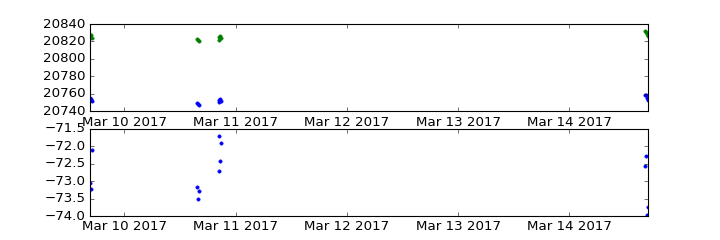

In [200]:
pl.figure(figsize=(9,3))
pl.subplot(2,1,1)
pl.plot(h_dt,h_abs,'.',h_dt,h_ord,'.')
pl.subplot(2,1,2)
pl.plot(h_dt,np.asarray(h_abs) - np.asarray(h_ord),'.')

## Plot of D absolutes, ordinates, baselines
Absolutes are in the top plot below, in blue.  These represent the declination angle of the field, as measured by the overhauser (with the pier correction applied), with direction measured by the theodolite.  Ordinates are also in the top plot, in green.  They represent the declination (from the sensor's H axis) calculated from the variometer's reading of the field corresponding to the times absolute measurements are taken.  Baselines, or the difference between the two are in the bottom plot, in blue.  Vertical axis units are degrees.  Horizontal axis units are unix timestamp (seconds since Jan 1, 1970).

<IPython.core.display.Javascript object>


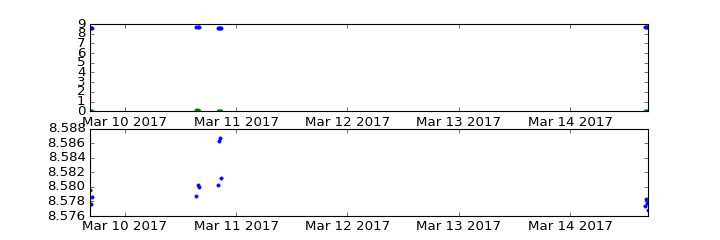

In [201]:
pl.figure(figsize=(9,3))
pl.subplot(2,1,1)
pl.plot(d_dt,d_abs,'.',d_dt,d_ord,'.')
pl.subplot(2,1,2)
pl.plot(d_dt,np.asarray(d_abs) - np.asarray(d_ord),'.')

## Plot of Z absolutes, ordinates, baselines
Absolutes are in the top plot below, in blue. These represent the field, as measured by the overhauser (with the pier correction applied), with direction measured by the theodolite. Ordinates are also in the top plot, in green. They represent the variometer's reading of the field corresponding to the times absolute measurements are taken. Baselines, or the difference between the two are in the bottom plot, in blue. Vertical axis units are nanoteslas. Horizontal axis units are unix timestamp (seconds since Jan 1, 1970).

<IPython.core.display.Javascript object>


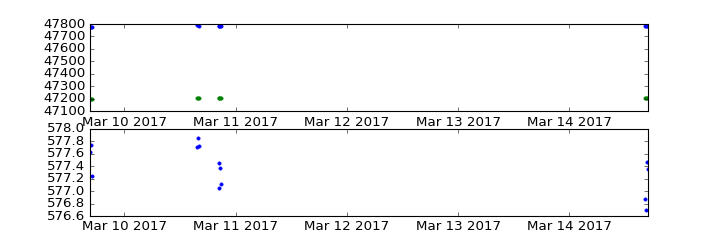

In [202]:
pl.figure(figsize=(9,3))
pl.subplot(2,1,1)
pl.plot(z_dt,z_abs,'.',z_dt,z_ord,'.')
pl.subplot(2,1,2)
pl.plot(z_dt,np.asarray(z_abs) - np.asarray(z_ord),'.')

### Note about averaging
The baselines have up to four values, corresponding to the up to four sets measured by the observer.  Pre-averaging these does not improve the transformation matrix calculated by the least squares solver in scipy/numpy.

## Calculate $(h,e,Z)_{variometer}$ from $(H,D,Z)_{ordinate}$ and $(X,Y,Z)_{absolute}$ from $(H,D,Z)_{absolute}$

In [203]:
# convert to NumPy arrays for convenience
h_abs_n = np.asarray(h_abs)
d_abs_n = np.asarray(d_abs)
z_abs_n = np.asarray(z_abs)
h_ord_n = np.asarray(h_ord)
d_ord_n = np.asarray(d_ord)
z_ord_n = np.asarray(z_ord)
z_t_n = np.asarray(z_t)

In [204]:
# convert to Cartesian coordinates
x_a = h_abs_n*np.cos(d_abs_n*np.pi/180)
y_a = h_abs_n*np.sin(d_abs_n*np.pi/180)
z_a = z_abs_n
h_o = h_ord_n*np.cos(d_ord_n*np.pi/180)
e_o = h_ord_n*np.sin(d_ord_n*np.pi/180)
z_o = z_ord_n

## Calculate Transform matrix

In [206]:
# No constraints, allow all degrees of freedom for M

# LHS, or dependent variables
abs_st = np.vstack([x_a,y_a,z_a,np.ones_like(x_a)])

# RHS, or independent variables
ord_st = np.vstack([h_o,e_o,z_o,np.ones_like(h_o)])

# regression matrix M that minimizes L2 norm
M, res, rank, sigma = spl.lstsq(ord_st.T,abs_st.T)

# clean up a bit by applying a threshold...this is mostly for aesthetics
tol = 1e-9
maskM = np.abs(M) > tol
M = maskM * M

# transpose matrix to operate on data whose vector components are stored
# as column vectors (this is NOT a universal standard, but common enough)
M = M.T

print np.array_str(M, precision=3)

[[  1.010e+00  -1.766e-01   1.630e-02  -1.289e+03]
 [  1.963e-01   9.238e-01   1.751e-01  -9.256e+03]
 [ -6.688e-02   5.999e-03   9.787e-01   2.974e+03]
 [  0.000e+00  -0.000e+00  -0.000e+00   1.000e+00]]


## Enter path to save adjusted statefile

In [207]:
path = './'

In [208]:
data = {
            'M11': M[0,0],
            'M12': M[0,1],
            'M13': M[0,2],
            'M14': M[0,3],
            'M21': M[1,0],
            'M22': M[1,1],
            'M23': M[1,2],
            'M24': M[1,3],
            'M31': M[2,0],
            'M32': M[2,1],
            'M33': M[2,2],
            'M34': M[2,3],
            'M41': M[3,0],
            'M42': M[3,1],
            'M43': M[3,2],
            'M44': M[3,3],
            'PC':  pier_correction
        }
with open(path + 'adj' + obs_code + '_state_.json', 'w') as f:
            f.write(json.dumps(data))

## Enter Start and End Times for Test month(s)

In [209]:
start2=UTCDateTime('2017-03-01T00:00:00Z')

In [210]:
end2=UTCDateTime('2017-03-14T23:59:59Z')

In [211]:
# pull raw data from Edge server
factory = EdgeFactory()

hezf = factory.get_timeseries(observatory=obs_code,
        interval='minute',
        type='variation',
        channels=('H', 'E', 'Z', 'F'),
        starttime=start2,
        endtime=end2)

In [212]:
# apply affine transformation matrix to raw data to generate Adjusted Data
raw = np.vstack([hezf[0].data,hezf[1].data,hezf[2].data,np.ones_like(hezf[0].data)])
adj = np.dot(M,raw)

In [213]:
# generate averaged static baselines, then estimate an alternate Adjusted Data stream
# (this amounts to the traditional method for [Quasi]Definitive Data processing)
h_pqqm = np.mean(h_abs_n - h_ord_n)
d_pqqm = np.mean(d_abs_n - d_ord_n)
z_pqqm = np.mean(z_abs_n - z_ord_n)

def_h = (raw[0]**2 + raw[1]**2)**0.5 + h_pqqm
def_d = np.arctan2(raw[1], raw[0]) * 180./np.pi + d_pqqm
def_z = raw[2] + z_pqqm
def_f = (def_h**2 + def_z**2)**0.5
def_x = def_h * np.cos(def_d * np.pi/180.)
def_y = def_h * np.sin(def_d * np.pi/180.)

## Plot of $\Delta F$ Over the Test Period
The left plot (black) shows adjusted delta F, the cyan shows adjusted delta F using average baselines over the period (instead of the transformation).  The blue on the right shows raw delta F.

<IPython.core.display.Javascript object>


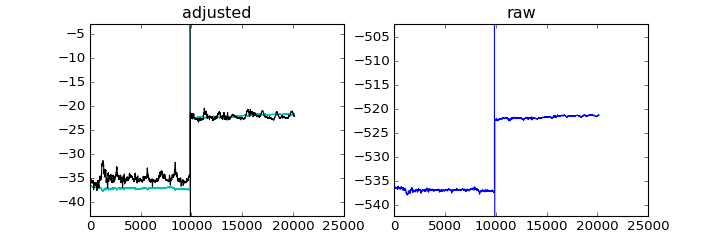

In [214]:
pl.figure(figsize=(9,3))

pl.subplot(1,2,1)

# plot "definitive" delta-F
def_delta_f = (def_f - hezf[3].data )
def_delta_f_med = np.nanmedian(def_delta_f)
pl.plot(def_delta_f,'c')

pl.hold(True)

# over-plot Adjusted Data delta-F
adj_delta_f = (adj[0]**2 + adj[1]**2 + adj[2]**2)**(0.5) - hezf[3].data
adj_delta_f_med = np.nanmedian(adj_delta_f)
pl.plot(adj_delta_f,'k')

pl.ylim(adj_delta_f_med - 20., adj_delta_f_med + 20.)
pl.title('adjusted')

pl.subplot(1,2,2)

# plot raw delta-F
raw_delta_f = (((hezf[0].data)**2 + (hezf[1].data)**2 + 
                (hezf[2].data)**2)**(0.5) - hezf[3].data)
raw_delta_f_med = np.nanmedian(raw_delta_f)

pl.plot(raw_delta_f,'b')

pl.ylim(raw_delta_f_med - 20.,raw_delta_f_med + 20.)

pl.title('raw')

## Plots of Adjusted X using Static Baseline, Affine Transform, and '$\Delta x$'

This is not quite the same as $\Delta F$, because $\Delta x$ is a comparison of two derived quantities.

<IPython.core.display.Javascript object>


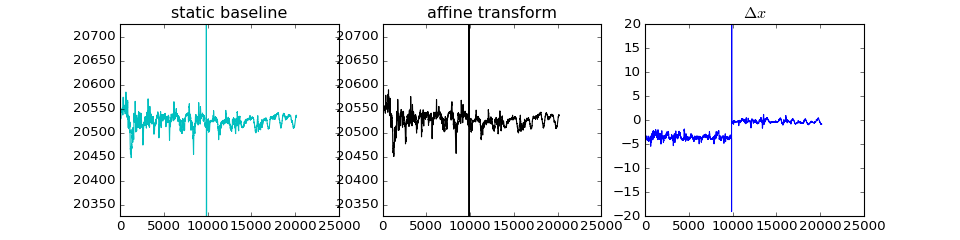

(-20.0, 20.0)

In [215]:
pl.figure(figsize=(12,3))
pl.subplot(1,3,1)
pl.plot(def_x,'c')
pl.title('static baseline')
def_x_med = np.nanmedian(def_x)
pl.ylim(def_x_med - 200., def_x_med + 200.)


pl.subplot(1,3,2)
pl.plot(adj[0],'k')
pl.title('affine transform')
pl.ylim(def_x_med - 200., def_x_med + 200.)


pl.subplot(1,3,3)
pl.plot(def_x - adj[0],'b')
pl.title('$\Delta x$')
pl.ylim(- 20.,  20.)


## ## Plots of Adjusted Y using Static Baseline, Affine Transform, and '$\Delta y$'

This is not quite the same as $\Delta F$, because $\Delta y$ is a comparison of two derived quantities.

<IPython.core.display.Javascript object>


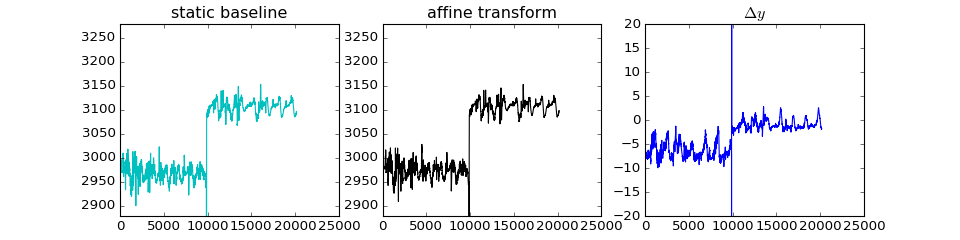

(-20.0, 20.0)

In [216]:
pl.figure(figsize=(12,3))
pl.subplot(1,3,1)
pl.plot(def_y,'c')
pl.title('static baseline')
def_y_med = np.nanmedian(def_y)
pl.ylim(def_y_med - 200., def_y_med + 200.)


pl.subplot(1,3,2)
pl.plot(adj[1],'k')
pl.title('affine transform')
pl.ylim(def_y_med - 200., def_y_med + 200.)


pl.subplot(1,3,3)
pl.plot(def_y - adj[1],'b')
pl.title('$\Delta y$')
pl.ylim(- 20.,  20.)


## Plots of Adjusted Z using Static Baseline, Affine Transform, and '$\Delta z$'

This is not quite the same as $\Delta F$, because $\Delta z$ is a comparison of two derived quantities.

<IPython.core.display.Javascript object>


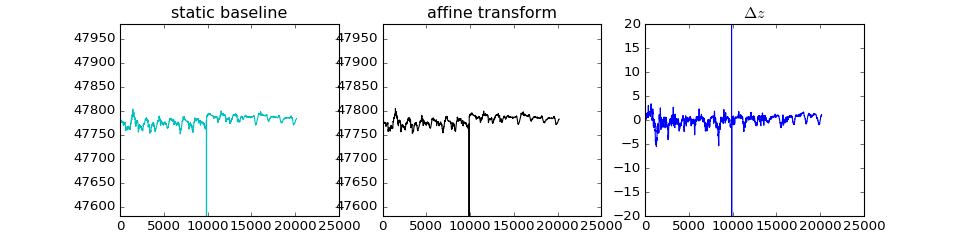

(-20.0, 20.0)

In [217]:
pl.figure(figsize=(12,3))
pl.subplot(1,3,1)
pl.plot(def_z,'c')
pl.title('static baseline')
def_z_med = np.nanmedian(def_z)
pl.ylim(def_z_med - 200., def_z_med + 200.)


pl.subplot(1,3,2)
pl.plot(adj[2],'k')
pl.title('affine transform')
pl.ylim(def_z_med - 200., def_z_med + 200.)


pl.subplot(1,3,3)
pl.plot(def_z - adj[2],'b')
pl.title('$\Delta z$')
pl.ylim(- 20.,  20.)